In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from tqdm.auto import tqdm as pbar
from pathlib import Path

from ihrem import stacks
from ihrem.timeslice import Win, ms
from ihrem import paths
from ihrem.analysis import sne, sleep
from ihrem.analysis import switches as sw

from ihrem.figs_comp import fig2

from IPython.display import display

import warnings
import logging
warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.INFO)

reg = paths.Registry.read_excel(paths.get_root() / 'registry_merged.xlsx')
exp_events = reg.get_all_events()
print(f'Found {len(reg.experiment_names)} experiments')

valid_win_9h = Win(ms(hours=2), ms(hours=11))

Found 57 experiments


# Single experiment

In [3]:
exp_name = 'GL903_20200716'

loader = reg.get_loader(exp_name)
load_chans = loader.channel_probes_to_global(reg.get_probe_channels(exp_name, 'CLA'))
loader = loader.sel_channels(load_chans)
assert np.all(loader.channels.index.values == [0, 1])

all_beta = reg.load_all_beta_norm(exp_name, add_max=False, exp_valid_win=Win(ms(hours=2), ms(hours=11)))

## Example x-corr (Fig 2. e)

In [4]:
example_win_idcs = [355200000, 403840000]

example_win = Win(*loader.idcs_to_ms(example_win_idcs))


In [5]:
%%time

xcorr = stacks.Stack.load_hdf(
    reg.get_path_xcorr_area(exp_name, sliding_win=10_000), 
    'xcorr'
)

xcorr = xcorr.sel_between(lag=(-50, +50))

CPU times: user 445 ms, sys: 6.08 s, total: 6.53 s
Wall time: 8.82 s


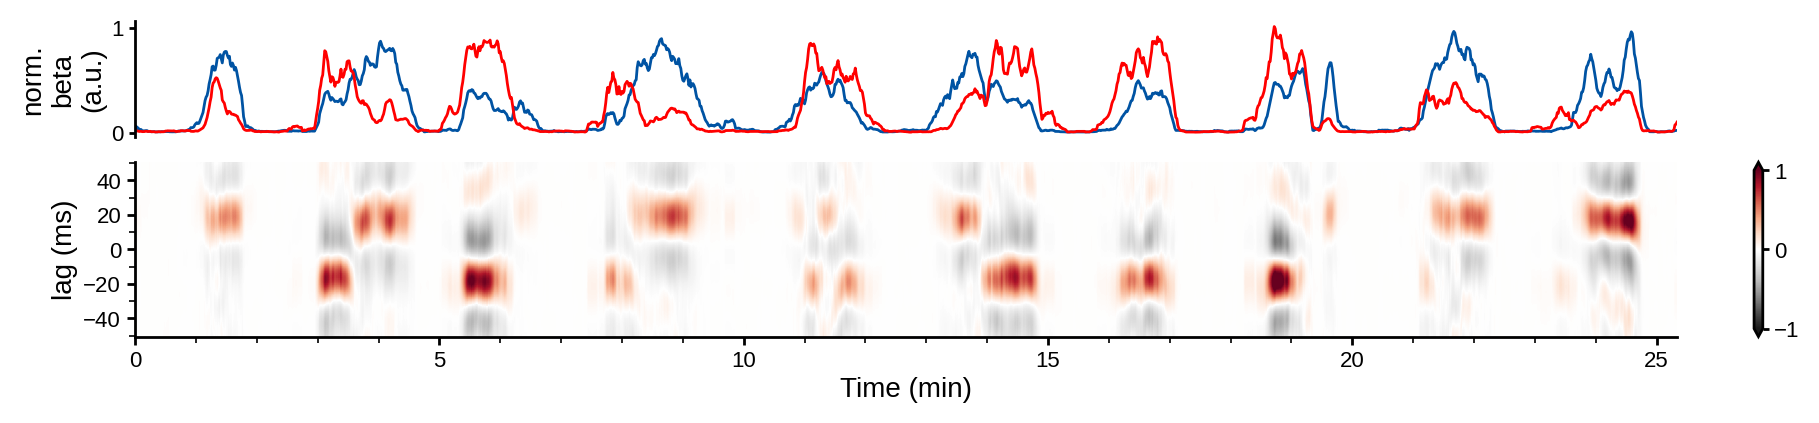

In [6]:
axs = fig2.plot_detailed_example_win(
    all_beta,
    xcorr,
    example_win,
)

axs.ravel()[0].figure.savefig(f'figs/{exp_name}_xcorr_{int(example_win.start)}_{int(example_win.stop)}.pdf')

In [7]:
raw = stacks.Stack.load_single_ms(loader, example_win, load_hz=200)

raw = raw.reset_coord()

## Beta band (EDF2 a)

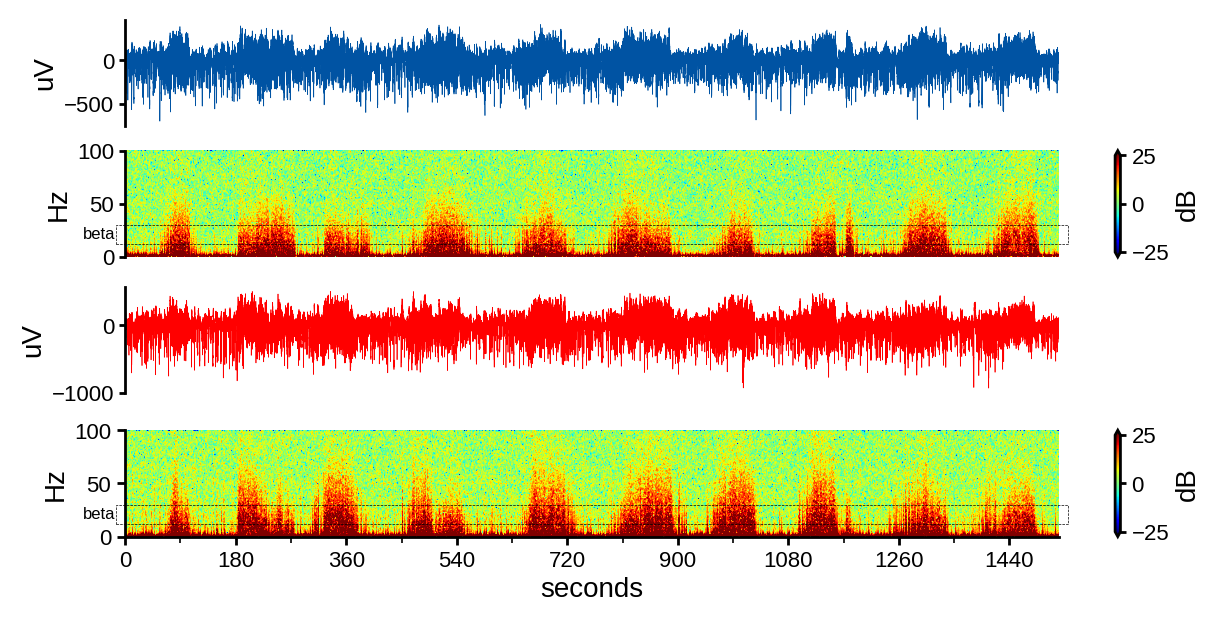

In [8]:
f = fig2.plot_specgram(raw, highlight_band='beta', cmap='jet')
f.savefig(f'figs/specgram.pdf')

## SN amplitude vs lag (Fig. 2 f)

In [9]:
all_sns = sne.SharpNegativeEvents.load_matched_sns(reg, exp_name)

all_sns.reg['match_amplitude_zscored'] = all_sns.get_match('amplitude_zscored')
all_sns.reg['match_amplitude_zscored_diff'] = all_sns.get_match_diff('amplitude_zscored')

matched 738,916/2.8139e+06 (26.3%) events


In [10]:
valid_sns = all_sns.sel_mask(all_sns.is_match_valid())

valid_sns

start_time  start_idx  start_prominence  start_rel_height  \
event_id                                                                
3         1.031562e+02       3301          0.557807         -0.003583   
4         1.221562e+02       3909          2.072811         -0.056968   
5         1.560312e+02       4993          3.355868          0.146519   
10        2.456250e+02       7860          2.691770         -0.307520   
11        2.699375e+02       8638          4.919533          0.642634   
...                ...        ...               ...               ...   
2813888   5.253247e+07   68239126          4.630327         -0.192288   
2813889   5.253257e+07   68242304          4.990232         -0.209832   
2813890   5.253263e+07   68244300          4.672891         -0.077026   
2813892   5.253273e+07   68247312          2.443721         -0.250221   
2813896   5.253291e+07   68253021          4.308454         -0.493989   

              ref_time   ref_idx  ref_prominence  ref_rel_height  \
event_id                                                           
3         1.062812e+02      3401        6.221174       -0.217225   
4         1.287500e+02      4120        9.408517       -0.839182   
5         1.674688e+02      5359       20.293083       -0.884404   
10        2.507188e+02      8023        8.007753       -2.160319   
11        2.763750e+02      8844       29.115206        1.745449   
...                ...       ...             ...             ...   
2813888   5.253248e+07  68239332       38.830554        4.935193   
2813889   5.253258e+07  68242502       32.994584        6.757825   
2813890   5.253264e+07  68244556       29.113638        4.572176   
2813892   5.253274e+07  68247583       22.010622        1.622801   
2813896   5.253291e+07  68253232       27.515786        5.541368   

             stop_time  stop_idx  ...  match_speed_diff  match_duration  \
event_id                          ...                                     
3         1.126250e+02      3604  ...         -0.884042        11.28125   
4         1.428750e+02      4572  ...         -6.376559         9.96875   
5         1.731562e+02      5541  ...         -1.298469        11.93750   
10        2.567188e+02      8215  ...         -4.082579         8.50000   
11        2.819375e+02      9022  ...          1.610019        10.28125   
...                ...       ...  ...               ...             ...   
2813888   5.253249e+07  68239544  ...         15.427644        20.34375   
2813889   5.253258e+07  68242678  ...         14.760550        11.28125   
2813890   5.253265e+07  68244765  ...         17.009200        20.50000   
2813892   5.253274e+07  68247765  ...         10.014600        12.68750   
2813896   5.253292e+07  68253431  ...         16.078202        14.90625   

          match_duration_diff  match_ref_time  match_ref_time_diff  \
event_id                                                             
3                     1.81250    1.042812e+02             -2.00000   
4                   -10.75000    1.290938e+02              0.34375   
5                    -5.18750    1.817500e+02             14.28125   
10                   -2.59375    2.153750e+02            -35.34375   
11                   -1.71875    2.907500e+02             14.37500   
...                       ...             ...                  ...   
2813888               7.28125    5.253250e+07             22.68750   
2813889              -0.40625    5.253260e+07             22.06250   
2813890               5.96875    5.253266e+07             20.78125   
2813892              -1.46875    5.253277e+07             28.59375   
2813896               2.09375    5.253294e+07             30.90625   

          match_start_time  match_start_time_diff  is_lead  \
event_id                                                     
3             9.665625e+01               -6.50000    False   
4             1.251562e+02                3.00000     True   
5             1.735938e+02               1

In [11]:
sns = valid_sns.sel_between(ref_time=valid_win_9h)

print('Abs delay:')
display(sns['match_ref_time_diff'].abs().describe().round(decimals=1))

print('By leadership:')
display(sns['match_ref_time_diff'].groupby(sns['is_lead']).describe().T)

Abs delay:


count    415564.0
mean         20.9
std           9.7
min           0.0
25%          15.4
50%          19.3
75%          24.5
max          52.0
Name: match_ref_time_diff, dtype: float64

By leadership:


is_lead          False           True
count    207804.000000  207760.000000
mean        -20.880694      20.885117
std           9.678929       9.675183
min         -51.968750       0.031250
25%         -24.468750      15.437500
50%         -19.312500      19.312500
75%         -15.437500      24.468750
max           0.000000      51.968750

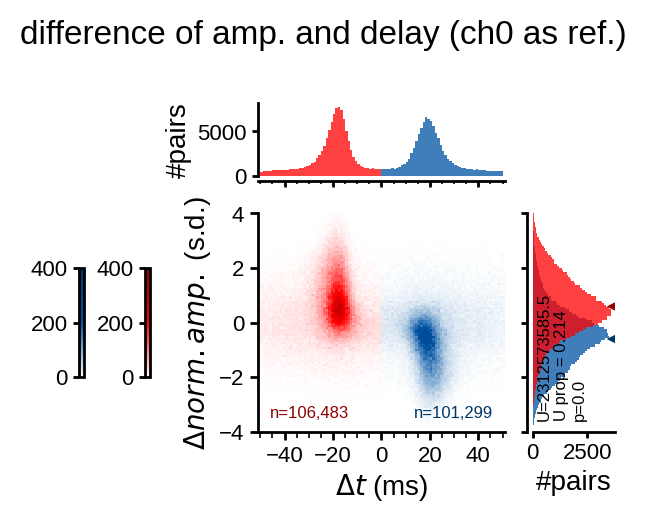

In [12]:
figure = fig2.plot_matched_amp_vs_time_diff(valid_sns.sel_between(ref_time=valid_win_9h), vmax_2d=400)
figure.savefig(f'figs/{exp_name}_sn_pairs_match_diffs_hist_9h.pdf')

In [13]:
win_valid_sns = valid_sns.sel_between(ref_time=valid_win_9h)

win_valid_sns

start_time  start_idx  start_prominence  start_rel_height  \
event_id                                                                
146472    7.200138e+06       4420          0.007772          0.067372   
146476    7.200314e+06      10056          0.066805          0.255342   
146479    7.200396e+06      12685          0.368241          0.036615   
146522    7.201577e+06      50452          0.136475          0.001482   
146524    7.201598e+06      51135          0.196120         -0.008040   
...                ...        ...               ...               ...   
2503737   3.959906e+07  115169826          4.762711         -0.666343   
2503747   3.959941e+07  115180999          5.279381         -0.460479   
2503750   3.959964e+07  115188339          6.351417         -0.262863   
2503751   3.959978e+07  115193032          0.604255          0.183514   
2503753   3.959991e+07  115197085          0.306556          0.092198   

              ref_time    ref_idx  ref_prominence  ref_rel_height  \
event_id                                                            
146472    7.200142e+06       4543        3.565788        1.277116   
146476    7.200325e+06      10399        8.439956        2.677077   
146479    7.200401e+06      12835        0.584271        1.558153   
146522    7.201580e+06      50568        0.268840        0.595378   
146524    7.201601e+06      51218        0.294185        0.527603   
...                ...        ...             ...             ...   
2503737   3.959906e+07  115170076       29.846645        7.349618   
2503747   3.959941e+07  115181206       28.242404        9.083223   
2503750   3.959964e+07  115188591       41.406938        9.702976   
2503751   3.959979e+07  115193375        6.422085        4.229263   
2503753   3.959991e+07  115197279        2.723089       -0.085095   

             stop_time   stop_idx  ...  match_speed_diff  match_duration  \
event_id                           ...                                     
146472    7.200147e+06       4711  ...        -17.474069        13.56250   
146476    7.200337e+06      10798  ...        -19.495724        13.71875   
146479    7.200405e+06      12956  ...         -6.419532        12.96875   
146522    7.201583e+06      50657  ...          0.893886        18.37500   
146524    7.201603e+06      51283  ...          0.862120        19.53125   
...                ...        ...  ...               ...             ...   
2503737   3.959907e+07  115170258  ...         14.575219        14.12500   
2503747   3.959942e+07  115181377  ...         15.121527        11.46875   
2503750   3.959965e+07  115188911  ...         22.224121        13.37500   
2503751   3.959980e+07  115193603  ...        -11.451278        13.87500   
2503753   3.959992e+07  115197434  ...        -11.201518        16.25000   

          match_duration_diff  match_ref_time  match_ref_time_diff  \
event_id                                                             
146472                4.46875    7.200115e+06            -27.25000   
146476               -9.46875    7.200296e+06            -29.06250   
146479                4.50000    7.200357e+06            -43.62500   
146522               11.96875    7.201583e+06              2.50000   
146524               14.90625    7.201624e+06             23.87500   
...                       ...             ...                  ...   
2503737               0.62500    3.959909e+07             20.15625   
2503747              -0.34375    3.959939e+07            -19.34375   
2503750              -4.50000    3.959967e+07             22.75000   
2503751              -3.96875    3.959976e+07            -32.53125   
2503753               5.34375    3.959990e+07            -19.81250   

          match_start_time  match_start_time_diff  is_lead  \
event_id                                                     
146472        7.200108e+06              -30.34375    False   
146476        7.200288e+06              -25.81250    False   
146479        7.

## SN bilateral shape (Fig. 2c)

In [14]:
load_win = (-60, +60)

all_picked = fig2.collect_isolated_sns(valid_sns, ref_channel=0, size_range=(-4, -3))

all_stacks = fig2.load_multiple_stacks(loader, all_picked, load_win)

load trace:   0%|          | 0/200 [00:00<?, ?it/s]

load trace:   0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
main = stacks.Stack.load_single_ms(
    loader,
    loader.win_ms.take_centered(ms(hours=1)),
)

signal_std = main.std('time').to_series()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

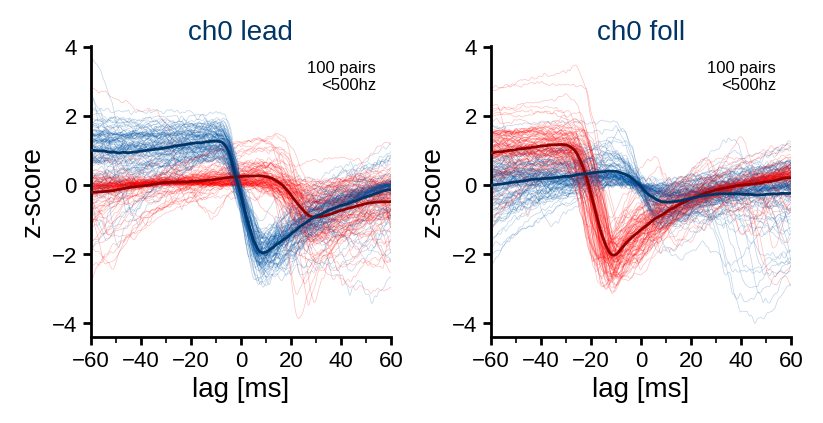

In [16]:
fig2.plot_sn_shapes(all_stacks, signal_std, load_win, exp_name)

# Histograms of lag of peak-correlations (Fig. 2 d)

In [17]:
from ihrem.analysis import xcorr_bestlags as xcb

USE_CACHE = True
MIN_XCORR_Q = .75

In [18]:
exp_names = [
    'GL957_20201005',
    'GL660_20191114',
    'GL1003_20201031',
    'GL1003_20201101',
    'GL1003_20201102',
    'GL598_20191205',
    'GL1071_20210710',
    'GL1018_20210811',
    'GL1018_20210812',
    'GL1018_20210813',
    'GL1234_20211208',
    'GL1234_20211210',
]


fig_desc = 'fig2_lag_max_xcorr'

In [19]:
%%time

exp_best_lags = xcb.compute_lags_best_xcorr(reg, exp_names, fig_desc='fig2_lag_max_xcorr', use_cache=USE_CACHE, lag_range=(-50, +50))

probs = xcb.compute_dist_best_lags(exp_best_lags, min_xcorr_q=MIN_XCORR_Q)

computing best lags


load x-corr:   0%|          | 0/22 [00:00<?, ?it/s]

loading /gpfs/laur/data/fenkl/spikes/neuropixel_bilateral/GL957_20201005_sleep2_g0/swsort/xcorr_p0c58_p1c90_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuronexus_bilateral/2019-11-14_17-42-16_GL660/swsort/xcorr_p0c28_p1c64_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuronexus_bilateral/2020-10-31_18-01-59_GL1003/swsort/xcorr_p0c32_p1c64_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuronexus_bilateral/2020-11-01_18-01-34_GL1003/swsort/xcorr_p0c32_p1c64_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuronexus_bilateral/2020-11-02_18-06-32_GL1003/swsort/xcorr_p0c32_p1c64_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuronexus_bilateral/2019-12-05_17-55-33_GL598/swsort/xcorr_p0c29_p1c64_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuropixel_OT/GL1071_20210710_sleep4_g0/swsort/xcorr_p0c50_p1c50_w1000_40hz.h5
loading /gpfs/laur/data/fenkl/spikes/neuropixel_OT/GL1071_20210710_sleep4_g0/swsort/xcorr_p0c50_p2c5_w1000_40hz.h5
loading /gpfs/laur/data/fenkl

best lags:   0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 3min 2s, sys: 3min 23s, total: 6min 25s
Wall time: 8min 11s


Saving /gpfs/gjor/personal/riquelmej/dev/ihrem/notebooks/figs/figs/fig2_lag_max_xcorr_summary_0.75q.pdf


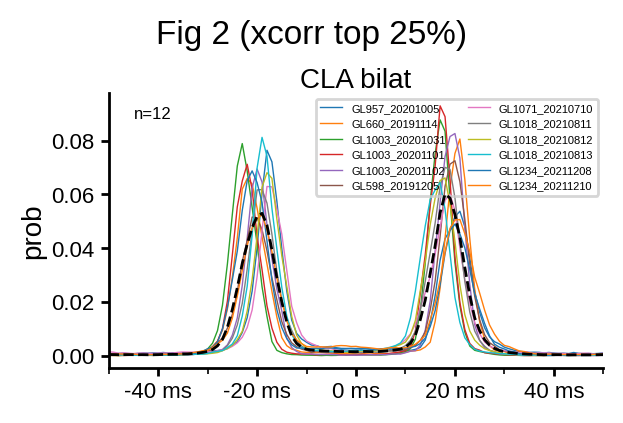

In [20]:
axs = xcb.plot_dists_best_lags(
    probs[['CLA bilat']],
    suptitle=f'Fig 2 (xcorr top {100*(1 - MIN_XCORR_Q):g}%)',
    figsize=(3, 2),
)

fig_path = Path(f'figs/{fig_desc}_summary_{MIN_XCORR_Q:g}q.pdf')
print(f'Saving {fig_path.absolute()}')
axs[0].figure.savefig(str(fig_path))

## Example x-corr (EDF3 a)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving:
figs/xcorr_GL957_20201005_CLA_bilat_09.00.pdf


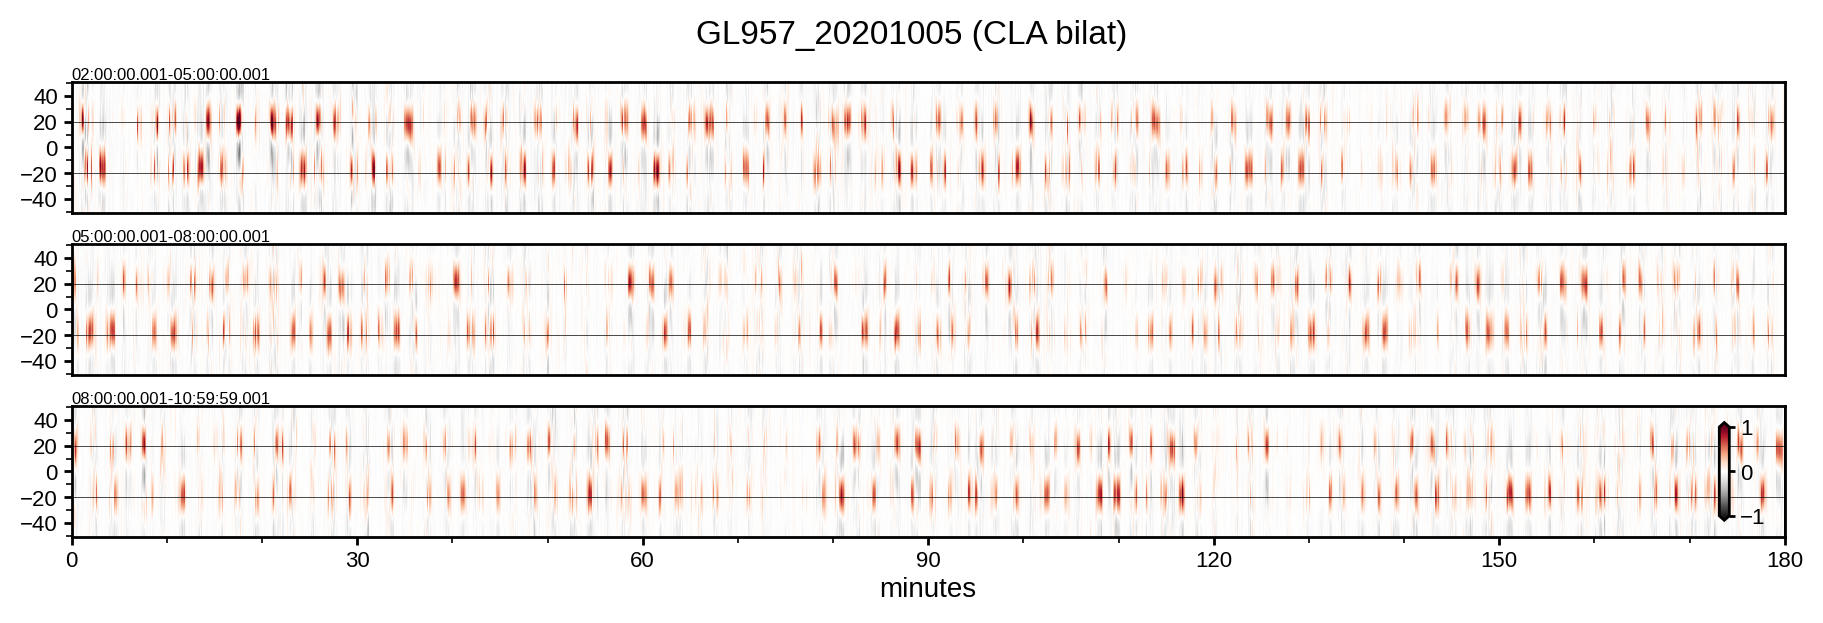

In [21]:
for exp_name in pbar(exp_names):
    path = reg.get_path_xcorr_area(exp_name, sliding_win=1_000)
    xcorr = stacks.Stack.load_hdf(path, 'xcorr')
    fig2.plot_example_xcorr(reg, exp_name, xcorr, desc='CLA bilat')

    break

# Sharp Waves independence (EDF 2 b & c)

In [22]:
exp_name = 'GL1142_20210904'
ref_ch = 1

loader = fig2.get_simple_loader(reg, exp_name)

In [23]:
process_win = valid_win_9h.take_centered(ms(hours=1))

main = stacks.Stack.load_single_ms(loader, process_win)

downsampled = main.low_pass(40).downsample(10).zscore().to_dataframe2d().T

downsampled

channel            0         1
time                          
21600000.0  0.492163 -1.415246
21600100.0  0.357987 -1.071824
21600200.0  0.077851 -1.116424
21600300.0 -0.381079 -1.091322
21600400.0 -2.725628 -1.120125
...              ...       ...
25199500.0 -0.251304 -2.789078
25199600.0  0.052121 -4.369448
25199700.0  0.319182 -3.375415
25199800.0  0.254198 -2.377739
25199900.0 -1.358601 -1.670823

[36000 rows x 2 columns]

In [24]:
%%time

swr = sleep.find_sharp_waves(main)

print(f'Found {len(swr):,g} SWR in {exp_name}')

Found 258 SWR in GL1142_20210904
CPU times: user 3.62 s, sys: 1.67 s, total: 5.29 s
Wall time: 5.29 s


In [25]:
all_beta = reg.load_all_beta_norm(exp_name, add_max=True, exp_valid_win=valid_win_9h)
rem_wins = sw.extract_rem_wins_from_log_beta_thresh_detour(all_beta, beta_thresh=0.3)

swr['cat'] = rem_wins.classify_events(swr['time'])['cat']
swr0 = swr.query(f'channel == {ref_ch}').copy()
swr0['value'] = downsampled[ref_ch].values[swr0['sample_idx']]

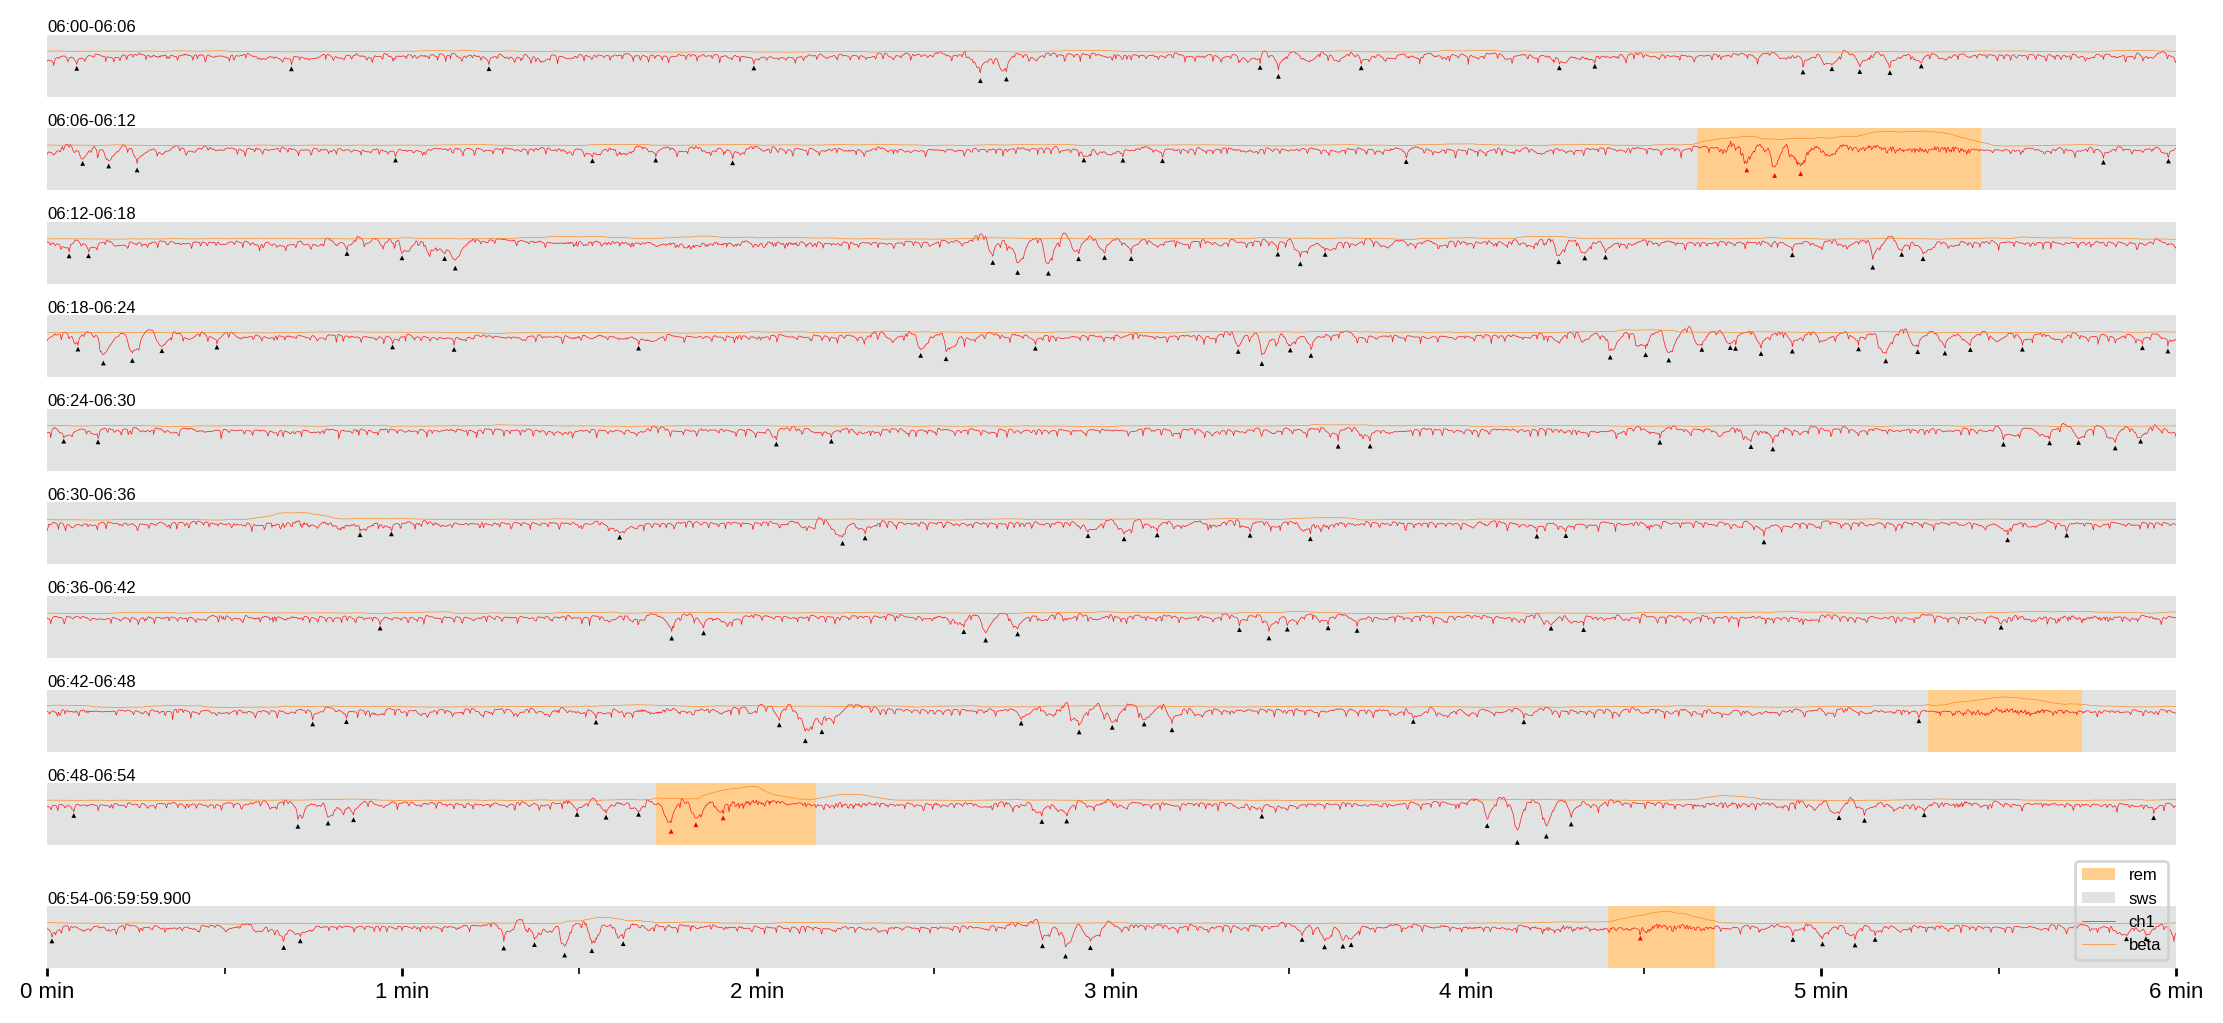

In [26]:
fig2.plot_swr_detection(downsampled, all_beta, rem_wins, swr0, which_ch=ref_ch)

## Multiple experiments

In [28]:
exp_names = [
    'GL660_20191114',
    'GL1003_20201101',
    'GL598_20191205',

    'GL1035_20210804',
    'GL1058_20210807',
]

for exp_name in pbar(exp_names):
    swr_path = Path(f'temp/cache_{exp_name}_swr.h5')

    if not swr_path.exists():
        swr = fig2.extract_swr(reg, exp_name, valid_win_9h)
        swr.to_hdf(str(swr_path), 'swr')

  0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
exp_swr = {
    exp_name: pd.read_hdf(f'temp/cache_{exp_name}_swr.h5', 'swr')
    for exp_name in pbar(exp_names)
}

for exp_name, swr in exp_swr.items():
    counts = swr.value_counts('channel')
    print(f'{counts[0]:,g}, {counts[1]:,g} swr in {exp_name}')

  0%|          | 0/5 [00:00<?, ?it/s]

1,261, 918 swr in GL660_20191114
1,018, 1,550 swr in GL1003_20201101
1,202, 1,056 swr in GL598_20191205
2,230, 658 swr in GL1035_20210804
3,735, 3,474 swr in GL1058_20210807


In [31]:
s_win = (-2000, +4000)

exp_swr_stack = {}

for exp_name, swr in pbar(exp_swr.items()):
    
    loader = fig2.get_simple_loader(reg, exp_name)

    exp_swr_stack[exp_name] = stacks.Stack.load_ms(
        loader,
        swr.query('channel==0')['time'].sample(1000, replace=False),
        win_ms=s_win,
    )

  0%|          | 0/5 [00:00<?, ?it/s]

load trace:   0%|          | 0/2000 [00:00<?, ?it/s]

load trace:   0%|          | 0/2000 [00:00<?, ?it/s]

load trace:   0%|          | 0/2000 [00:00<?, ?it/s]

load trace:   0%|          | 0/2000 [00:00<?, ?it/s]

load trace:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

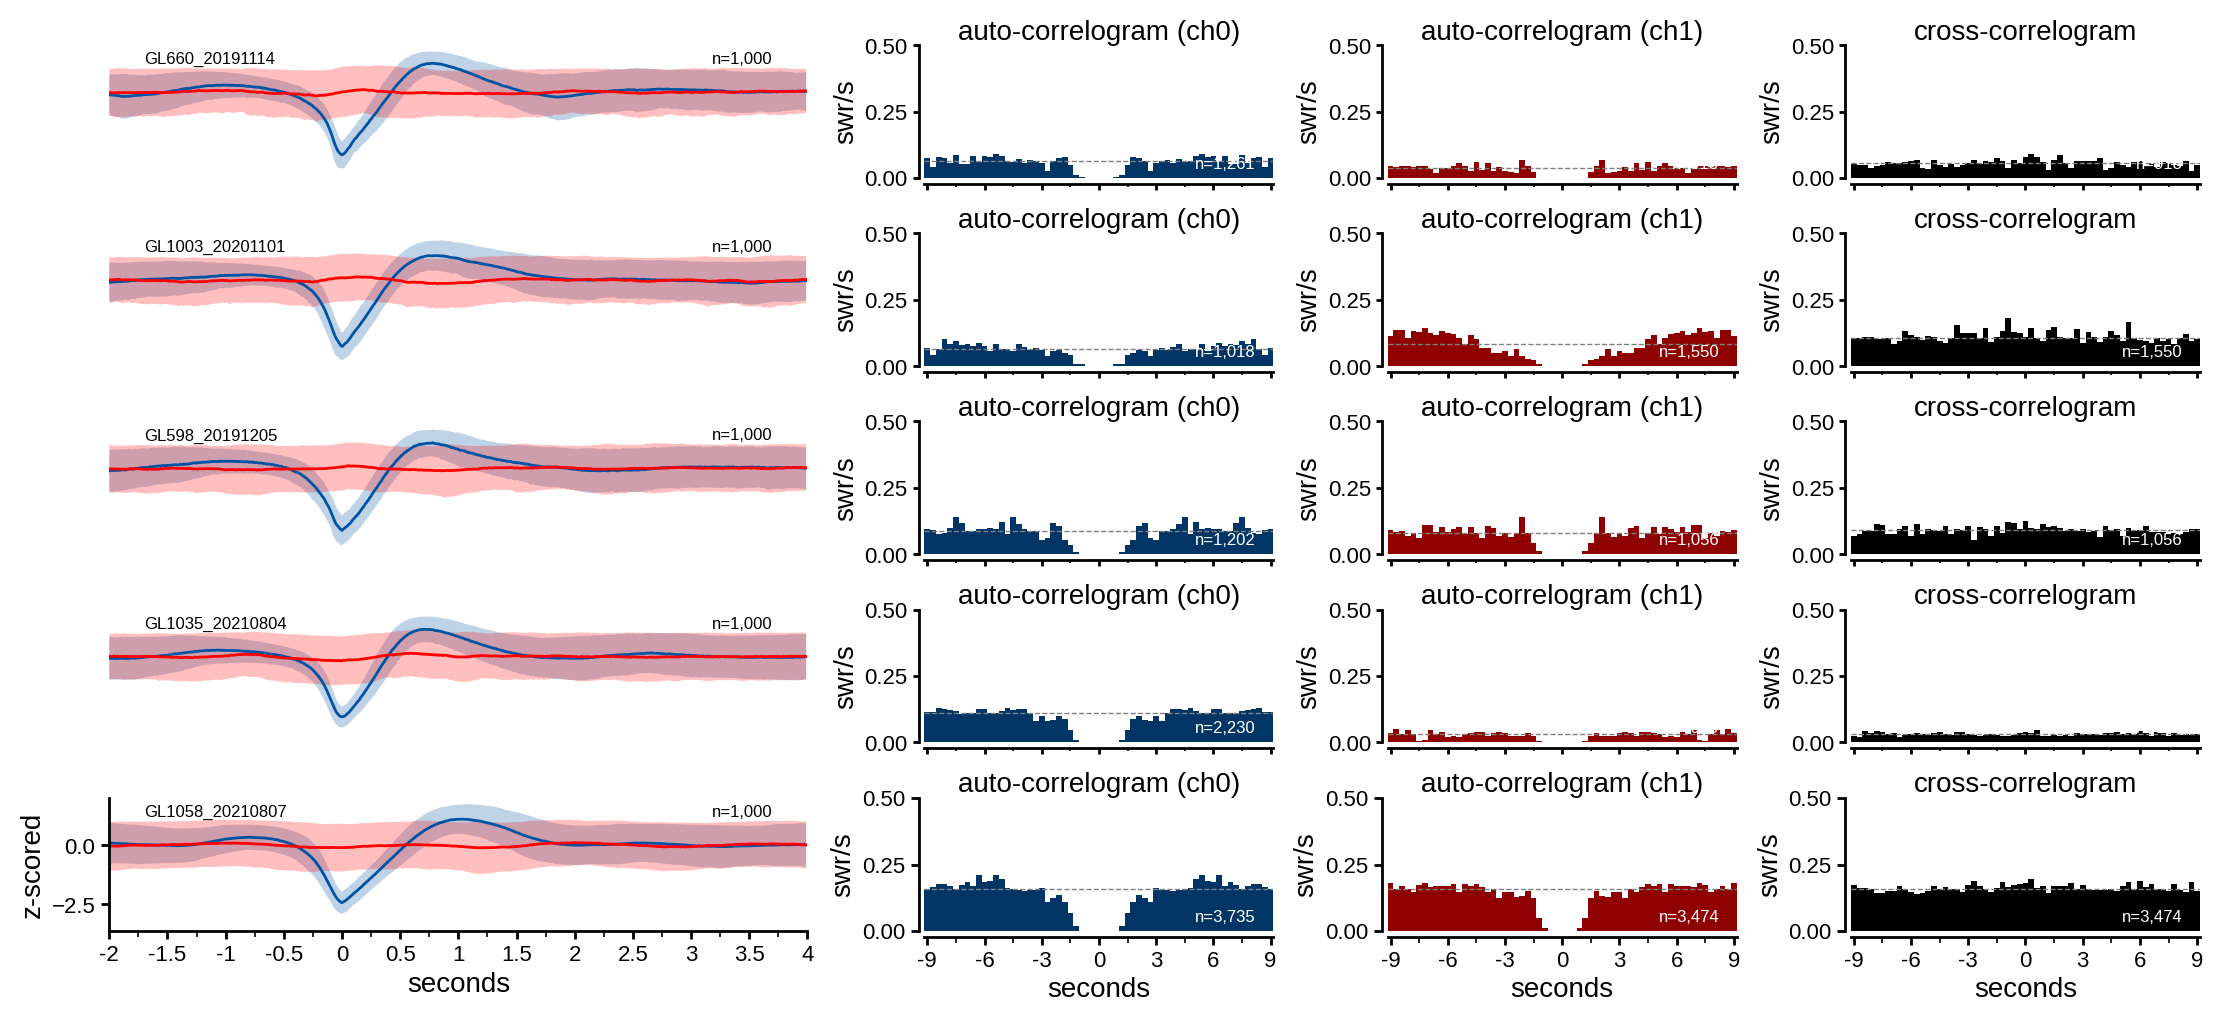

In [32]:
f = fig2.plot_swr_triggered(exp_swr, exp_swr_stack, s_win)
f.savefig('figs/swr_averages.pdf')